# Siamese Neural Network for FDA Recalls-Regulations Matching

## Built and Trained from Scratch using PyTorch

This notebook implements a Siamese Neural Network architecture from scratch (no pre-trained weights) to learn similarity between **FDA recall reasons** and regulations.

### Key Differences from Adverse Events Version:
- **Uses Recalls Data**: FDA recalls with clear, stated reasons for recall
- **Reason-Based Matching**: Matches recall reasons to relevant regulations
- **Drugs Only**: Focuses on Drugs (excludes Biologics and Medical Devices)

### Architecture:
- Custom embedding layer (random initialization)
- Bidirectional LSTM layers
- Fully connected layers
- Cosine similarity computation
- Trained end-to-end with PyTorch

### Purpose:
- Learn semantic similarity between recall reasons and regulations
- Match recalls to relevant FDA regulations based on stated reasons

## Install and Import Libraries

In [31]:
# Install required packages
import subprocess
import sys

packages = [
    "torch",
    "torchvision",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "tqdm",
    "pyarrow"
]

for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

print("\n✓ All packages ready")

✓ torch already installed
✓ torchvision already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed
Installing scikit-learn...
✓ tqdm already installed
✓ pyarrow already installed

✓ All packages ready


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import pickle
from collections import Counter
import re

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ Libraries imported
PyTorch version: 2.9.0
CUDA available: False


## Setup Paths and Configuration

In [33]:
# Setup paths
BASE_DIR = Path("/Users/Kay Michnicki/AllCode/FDA Data Scraping")

# Data directories
RECALLS_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "recalls"
REGULATIONS_DATA_DIR = BASE_DIR / "fda_output_cleaned"
OUTPUT_DIR = BASE_DIR / "siamese_network_recalls_output"
OUTPUT_DIR.mkdir(exist_ok=True)

# Model configuration
EMBEDDING_DIM = 128  # Dimension of word embeddings
HIDDEN_DIM = 256  # LSTM hidden dimension
NUM_LAYERS = 2  # Number of LSTM layers
DROPOUT = 0.3
MAX_VOCAB_SIZE = 10000  # Maximum vocabulary size
MAX_SEQ_LENGTH = 512  # Maximum sequence length
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("SIAMESE NEURAL NETWORK - RECALLS TO REGULATIONS MATCHING")
print(f"\nBase directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nModel Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  LSTM layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Max sequence length: {MAX_SEQ_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {DEVICE}")

SIAMESE NEURAL NETWORK - RECALLS TO REGULATIONS MATCHING

Base directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping
Output directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_recalls_output

Model Configuration:
  Embedding dimension: 128
  Hidden dimension: 256
  LSTM layers: 2
  Dropout: 0.3
  Max sequence length: 512
  Batch size: 32
  Learning rate: 0.001
  Epochs: 10
  Device: cpu


## Load and Prepare Recalls Data

In [34]:
# Load recalls data
print("Loading recalls data...")
recalls_file = RECALLS_DATA_DIR / "recalls.parquet"

if recalls_file.exists():
    df_recalls = pd.read_parquet(recalls_file)
    print(f"✓ Loaded {len(df_recalls):,} recalls")
    print(f"\nRecalls data columns: {list(df_recalls.columns)}")
    print(f"\nProduct types:")
    print(df_recalls['product_type'].value_counts())
else:
    print(f"⚠ Recalls file not found: {recalls_file}")
    df_recalls = pd.DataFrame()

# Load regulations data
print("\nLoading regulations data...")
regulations_file = REGULATIONS_DATA_DIR / "fda_cleaned.parquet"
if regulations_file.exists():
    df_regulations = pd.read_parquet(regulations_file)
    print(f"✓ Loaded {len(df_regulations):,} regulations")
    print(f"\nRegulation categories:")
    print(df_regulations['category'].value_counts())
else:
    print(f"⚠ Regulations file not found: {regulations_file}")
    df_regulations = pd.DataFrame()

# Prepare recall text from reason_for_recall
# Recalls have clear, stated reasons - use those directly
if len(df_recalls) > 0 and 'reason_for_recall' in df_recalls.columns:
    # Create recall text combining reason and product description for context
    def create_recall_text(row):
        parts = []
        # Primary: reason for recall (this is what we want to match)
        if pd.notna(row.get('reason_for_recall')):
            parts.append(f"Reason for recall: {row['reason_for_recall']}")
        # Add product context
        if pd.notna(row.get('product_description')):
            parts.append(f"Product: {row['product_description']}")
        return ". ".join(parts) if parts else "No information available"
    
    df_recalls['recall_text'] = df_recalls.apply(create_recall_text, axis=1)
    
    # Map product_type to category for matching
    # Note: recalls use 'drug' and 'device', regulations use 'Drugs', 'Biologics', 'MedicalDevices'
    def map_product_type_to_category(row):
        product_type = str(row.get('product_type', '')).lower()
        # Check if it's a biologic by keywords in product description
        product_desc = str(row.get('product_description', '')).lower()
        if any(kw in product_desc for kw in ['biologic', 'vaccine', 'blood', 'plasma', 'biotechnology']):
            return 'Biologics'
        elif product_type == 'drug':
            return 'Drugs'
        elif product_type == 'device':
            return 'MedicalDevices'
        else:
            return 'Drugs'  # Default
    
    df_recalls['product_category'] = df_recalls.apply(map_product_type_to_category, axis=1)
    
    print(f"\n✓ Recalls prepared:")
    print(f"  Total recalls: {len(df_recalls):,}")
    print(f"  Recalls with reasons: {df_recalls['reason_for_recall'].notna().sum():,}")
    print(f"  Category distribution:")
    print(df_recalls['product_category'].value_counts())
    
    # Show sample recall reasons
    print(f"\nSample recall reasons:")
    sample_recalls = df_recalls[df_recalls['reason_for_recall'].notna()].head(3)
    for idx, row in sample_recalls.iterrows():
        reason = str(row['reason_for_recall'])[:150]
        print(f"  {row.get('recall_number', 'N/A')}: {reason}...")

print(f"\n✓ Data loaded and prepared")
print(f"  Recalls: {len(df_recalls):,}")
print(f"  Regulations: {len(df_regulations):,}")

Loading recalls data...
✓ Loaded 2,000 recalls

Recalls data columns: ['recall_number', 'recall_initiation_date', 'product_description', 'reason_for_recall', 'product_type', 'recalling_firm', 'status', 'raw_data']

Product types:
product_type
drug      1000
device    1000
Name: count, dtype: int64

Loading regulations data...
✓ Loaded 1,880 regulations

Regulation categories:
category
Drugs             981
MedicalDevices    453
Biologics         446
Name: count, dtype: int64

✓ Recalls prepared:
  Total recalls: 2,000
  Recalls with reasons: 2,000
  Category distribution:
product_category
Drugs             991
MedicalDevices    929
Biologics          80
Name: count, dtype: int64

Sample recall reasons:
  D-321-2016: Lack of Assurance of Sterility:  A recall of all compounded sterile preparations within expiry is being initiated due to observations associated with ...
  D-0080-2021: CGMP Deviations: Next Advanced Antibacterial Hand Sanitizer was found to be below the label claim for eth

## Build Vocabulary from Scratch

In [35]:
class Vocabulary:
    """Build vocabulary from scratch - no pre-trained embeddings"""
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()
    
    def build_vocab(self, texts, max_vocab_size=10000):
        """Build vocabulary from text corpus"""
        print("Building vocabulary from scratch...")
        
        # Tokenize and count words
        for text in tqdm(texts, desc="Processing texts"):
            if pd.notna(text):
                words = self._tokenize(str(text))
                self.word_counts.update(words)
        
        # Add most common words to vocabulary
        for word, count in self.word_counts.most_common(max_vocab_size - 2):
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        
        print(f"✓ Vocabulary built: {len(self.word2idx):,} words")
        return self
    
    def _tokenize(self, text):
        """Simple tokenization"""
        text = text.lower()
        # Remove special characters, keep alphanumeric and spaces
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text.split()
    
    def encode(self, text, max_length=512):
        """Encode text to sequence of indices"""
        words = self._tokenize(str(text) if pd.notna(text) else "")
        indices = [self.word2idx.get(word, 1) for word in words[:max_length]]  # 1 = <UNK>
        # Pad or truncate
        if len(indices) < max_length:
            indices.extend([0] * (max_length - len(indices)))  # 0 = <PAD>
        else:
            indices = indices[:max_length]
        return indices
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary from both recall reasons and regulations
print("Building vocabulary from all texts...")
all_texts = []
if len(df_recalls) > 0 and 'recall_text' in df_recalls.columns:
    all_texts.extend(df_recalls['recall_text'].dropna().tolist())
if len(df_regulations) > 0:
    all_texts.extend(df_regulations['clean_text'].dropna().tolist())

vocab = Vocabulary()
vocab.build_vocab(all_texts, max_vocab_size=MAX_VOCAB_SIZE)

# Save vocabulary
vocab_file = OUTPUT_DIR / "vocabulary.pkl"
with open(vocab_file, 'wb') as f:
    pickle.dump(vocab, f)
print(f"✓ Vocabulary saved to {vocab_file}")

Building vocabulary from all texts...
Building vocabulary from scratch...


Processing texts: 100%|██████████| 3880/3880 [00:02<00:00, 1475.58it/s] 

✓ Vocabulary built: 10,000 words
✓ Vocabulary saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_recalls_output/vocabulary.pkl


## Define Siamese Neural Network Architecture (Built from Scratch)

In [36]:
class SiameseNetwork(nn.Module):
    """
    Siamese Neural Network built from scratch
    No pre-trained weights - all randomly initialized
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(SiameseNetwork, self).__init__()
        
        # Embedding layer (random initialization - built from scratch)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM layers (built from scratch)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers (built from scratch)
        lstm_output_dim = hidden_dim * 2  # bidirectional
        self.fc1 = nn.Linear(lstm_output_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        
    def forward_one(self, x):
        """Process one input sequence"""
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use last hidden state (concatenate forward and backward)
        # hidden shape: (num_layers * 2, batch, hidden_dim)
        # Take the last layer's forward and backward hidden states
        forward_hidden = hidden[-2, :, :]  # Last forward layer
        backward_hidden = hidden[-1, :, :]  # Last backward layer
        combined_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        # Fully connected layers
        out = self.fc1(combined_hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
    
    def forward(self, input1, input2):
        """Process two inputs and compute similarity"""
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        
        # Compute cosine similarity
        # Normalize vectors
        output1_norm = torch.nn.functional.normalize(output1, p=2, dim=1)
        output2_norm = torch.nn.functional.normalize(output2, p=2, dim=1)
        
        # Cosine similarity
        similarity = torch.sum(output1_norm * output2_norm, dim=1)
        
        return similarity, output1, output2

# Initialize model
model = SiameseNetwork(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("SIAMESE NEURAL NETWORK ARCHITECTURE (BUILT FROM SCRATCH)")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {DEVICE}")

SIAMESE NEURAL NETWORK ARCHITECTURE (BUILT FROM SCRATCH)
SiameseNetwork(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
)

Total parameters: 3,844,608
Trainable parameters: 3,844,608
Model device: cpu


## Create Dataset Class

In [37]:
class SiameseDataset(Dataset):
    """Dataset for Siamese network training"""
    def __init__(self, pairs, labels, vocab, max_length=512):
        self.pairs = pairs  # List of (text1, text2) tuples
        self.labels = labels  # List of similarity labels (0 or 1)
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        text1, text2 = self.pairs[idx]
        label = self.labels[idx]
        
        # Encode texts
        encoded1 = self.vocab.encode(text1, self.max_length)
        encoded2 = self.vocab.encode(text2, self.max_length)
        
        return (
            torch.tensor(encoded1, dtype=torch.long),
            torch.tensor(encoded2, dtype=torch.long),
            torch.tensor(label, dtype=torch.float)
        )

print("✓ Dataset class defined")

✓ Dataset class defined


## Create Training Data (Positive and Negative Pairs)

In [38]:
# Filter for only Drugs (exclude Biologics and MedicalDevices)
TARGET_CATEGORIES = ['Drugs']
print(f"\nFiltering data for categories: {TARGET_CATEGORIES}")

# Filter recalls to only Drugs
df_recalls_filtered = df_recalls[df_recalls['product_category'].isin(TARGET_CATEGORIES)].copy()
print(f"  Recalls after filtering: {len(df_recalls_filtered):,}")
print(f"  Category distribution:")
print(df_recalls_filtered['product_category'].value_counts())

# Filter regulations to only Drugs
df_regulations_filtered = df_regulations[df_regulations['category'].isin(TARGET_CATEGORIES)].copy()
print(f"\n  Regulations after filtering: {len(df_regulations_filtered):,}")
print(f"  Category distribution:")
print(df_regulations_filtered['category'].value_counts())

# Create training pairs
print("\nCreating training pairs...")

# For positive pairs: match recall reasons with regulations from same category
positive_pairs = []
negative_pairs = []

# Sample data for training (to keep it manageable)
max_samples = min(5000, len(df_recalls_filtered), len(df_regulations_filtered))

if len(df_recalls_filtered) > 0 and len(df_regulations_filtered) > 0:
    # Sample recalls (only Drugs)
    df_recalls_sample = df_recalls_filtered[df_recalls_filtered['recall_text'].notna()].copy()
    df_recalls_sample = df_recalls_sample[df_recalls_sample['recall_text'].str.len() > 10].copy()
    
    if len(df_recalls_sample) == 0:
        print("⚠ Warning: No recalls with valid recall_text found after filtering")
        print("  Creating recall_text from reason_for_recall if available...")
        # Fallback: create recall_text if it doesn't exist
        if 'reason_for_recall' in df_recalls_filtered.columns:
            df_recalls_filtered['recall_text'] = df_recalls_filtered.apply(
                lambda row: f"Reason for recall: {row.get('reason_for_recall', '')}. Product: {row.get('product_description', '')}",
                axis=1
            )
            df_recalls_sample = df_recalls_filtered[df_recalls_filtered['recall_text'].str.len() > 10].copy()
    
    if len(df_recalls_sample) > 0:
        df_recalls_sample = df_recalls_sample.sample(
            n=min(max_samples, len(df_recalls_sample)), 
            random_state=42
        )
        
        # Create positive pairs (same category)
        for idx, recall_row in tqdm(df_recalls_sample.iterrows(), total=len(df_recalls_sample), desc="Creating pairs"):
            recall_text = recall_row.get('recall_text', '')
            recall_category = recall_row.get('product_category', 'Drugs')
            
            if pd.notna(recall_text) and len(str(recall_text)) > 10:
                # Positive: regulation from same category
                regs_same_cat = df_regulations_filtered[df_regulations_filtered['category'] == recall_category]
                if len(regs_same_cat) > 0:
                    reg_row = regs_same_cat.sample(n=1, random_state=idx).iloc[0]
                    # Store positive regulation for negative pair creation
                    reg_text = reg_row.get('clean_text', '')
                    if pd.notna(reg_text) and len(str(reg_text)) > 10:
                        positive_pairs.append((recall_text, str(reg_text)))
                
                # Negative: regulation from different category OR random mismatch within same category
                # First try different category
                regs_diff_cat = df_regulations_filtered[df_regulations_filtered['category'] != recall_category]
                if len(regs_diff_cat) > 0:
                    reg_row = regs_diff_cat.sample(n=1, random_state=idx+10000).iloc[0]
                    reg_text = reg_row.get('clean_text', '')
                    if pd.notna(reg_text) and len(str(reg_text)) > 10:
                        negative_pairs.append((recall_text, str(reg_text)))
                else:
                    # If no different category (e.g., Drugs only), create negative pairs by random mismatch
                    regs_same_cat = df_regulations_filtered[df_regulations_filtered['category'] == recall_category]
                    if len(regs_same_cat) > 1:  # Need at least 2 regulations
                        # Get a different random regulation (not the one used for positive pair)
                        # First get the positive regulation index
                        positive_reg_idx = regs_same_cat.sample(n=1, random_state=idx).index[0]
                        # Get other regulations (excluding the positive one)
                        other_regs = regs_same_cat[regs_same_cat.index != positive_reg_idx]
                        if len(other_regs) > 0:
                            reg_row = other_regs.sample(n=1, random_state=idx+20000).iloc[0]
                            reg_text = reg_row.get('clean_text', '')
                            if pd.notna(reg_text) and len(str(reg_text)) > 10:
                                negative_pairs.append((recall_text, str(reg_text)))
    else:
        print("⚠ Error: No valid recalls found for training pair creation")
min_pairs = min(len(positive_pairs), len(negative_pairs))
positive_pairs = positive_pairs[:min_pairs]
negative_pairs = negative_pairs[:min_pairs]

# Combine pairs
all_pairs = positive_pairs + negative_pairs
all_labels = [1.0] * len(positive_pairs) + [0.0] * len(negative_pairs)

print(f"\n✓ Training pairs created:")
print(f"  Positive pairs: {len(positive_pairs):,}")
print(f"  Negative pairs: {len(negative_pairs):,}")
print(f"  Total pairs: {len(all_pairs):,}")

# Check if we have pairs before splitting
if len(all_pairs) == 0:
    raise ValueError(
        "No training pairs created! This may happen if:\n"
        "1. No valid recall_text found in recalls data\n"
        "2. No matching regulations found\n"
        "3. All text fields are too short (< 10 characters)\n"
        "Please check your data and ensure recall_text column exists and contains valid data."
    )

# Split into train/validation
if len(all_pairs) < 10:
    print(f"⚠ Warning: Very few pairs ({len(all_pairs)}). Consider using more data.")
    # Use a smaller test size if we have very few pairs
    test_size = min(0.2, max(0.1, 2 / len(all_pairs))) if len(all_pairs) > 2 else 0.0
    if test_size > 0:
        train_pairs, val_pairs, train_labels, val_labels = train_test_split(
            all_pairs, all_labels, test_size=test_size, random_state=42, stratify=all_labels if len(set(all_labels)) > 1 else None
        )
    else:
        # Use all data for training if too few pairs
        train_pairs, val_pairs = all_pairs, []
        train_labels, val_labels = all_labels, []
        print("⚠ Using all data for training (no validation split due to small dataset)")
else:
    train_pairs, val_pairs, train_labels, val_labels = train_test_split(
        all_pairs, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )

print(f"\n✓ Data split:")
print(f"  Training pairs: {len(train_pairs):,}")
print(f"  Validation pairs: {len(val_pairs):,}")

# Create datasets
train_dataset = SiameseDataset(train_pairs, train_labels, vocab, MAX_SEQ_LENGTH)
val_dataset = SiameseDataset(val_pairs, val_labels, vocab, MAX_SEQ_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Data loaders created")


Filtering data for categories: ['Drugs']
  Recalls after filtering: 991
  Category distribution:
product_category
Drugs    991
Name: count, dtype: int64

  Regulations after filtering: 981
  Category distribution:
category
Drugs    981
Name: count, dtype: int64

Creating training pairs...


Creating pairs: 100%|██████████| 981/981 [00:02<00:00, 469.58it/s]


✓ Training pairs created:
  Positive pairs: 981
  Negative pairs: 981
  Total pairs: 1,962

✓ Data split:
  Training pairs: 1,569
  Validation pairs: 393
✓ Data loaders created


## Training Loop

In [39]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for similarity (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training history
train_losses = []
val_losses = []
val_accuracies = []

print("Starting training from scratch...")

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 3

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for batch_idx, (text1, text2, labels) in enumerate(train_pbar):
        text1 = text1.to(DEVICE)
        text2 = text2.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass
        optimizer.zero_grad()
        similarity, _, _ = model(text1, text2)
        
        # Compute loss (convert similarity [-1,1] to [0,1] for BCE)
        # Use sigmoid to convert similarity to probability
        similarity_prob = torch.sigmoid(similarity)
        loss = criterion(similarity, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_batches = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for text1, text2, labels in val_pbar:
            text1 = text1.to(DEVICE)
            text2 = text2.to(DEVICE)
            labels = labels.to(DEVICE)
            
            similarity, _, _ = model(text1, text2)
            similarity_prob = torch.sigmoid(similarity)
            
            loss = criterion(similarity, labels)
            val_loss += loss.item()
            val_batches += 1
            
            # Calculate accuracy
            predictions = (similarity_prob > 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / val_batches
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
        }, OUTPUT_DIR / 'best_model.pth')
        print(f"  ✓ Saved best model (val_loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print("-" * 60)

print("\n✓ Training completed!")

Starting training from scratch...


Epoch 1/10 [Val]: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s, loss=0.7143, acc=0.4987]



Epoch 1/10:
  Train Loss: 0.7057
  Val Loss: 0.6960
  Val Accuracy: 0.4987
  Learning Rate: 0.001000
  ✓ Saved best model (val_loss: 0.6960)
------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s, loss=0.6646, acc=0.5013]



Epoch 2/10:
  Train Loss: 0.6956
  Val Loss: 0.6961
  Val Accuracy: 0.5013
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s, loss=0.7371, acc=0.5089]



Epoch 3/10:
  Train Loss: 0.6873
  Val Loss: 0.7264
  Val Accuracy: 0.5089
  Learning Rate: 0.001000
------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s, loss=0.6877, acc=0.4733]


Epoch 4/10:
  Train Loss: 0.6728
  Val Loss: 0.7271
  Val Accuracy: 0.4733
  Learning Rate: 0.000500

Early stopping triggered after 4 epochs

✓ Training completed!


## Plot Training History

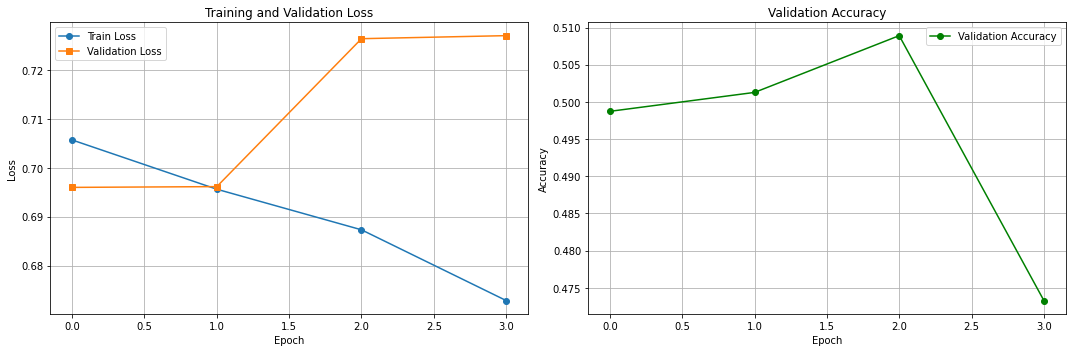

✓ Saved: training_history.png


In [40]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_history.png")

## Evaluate Model

✓ Loaded best model from epoch 1


Evaluating: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]



MODEL EVALUATION RESULTS
Accuracy:  0.4987
Precision: 0.4987
Recall:    1.0000
F1 Score:  0.6655


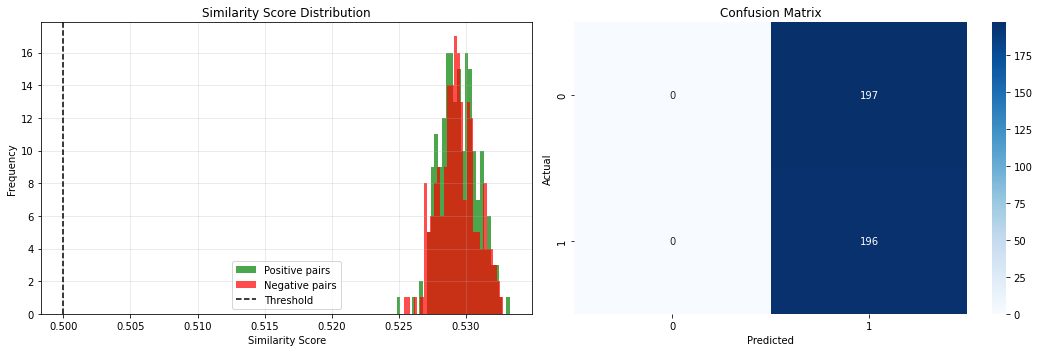

✓ Saved: evaluation_results.png


In [41]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on validation set
model.eval()
all_predictions = []
all_labels = []
all_similarities = []

with torch.no_grad():
    for text1, text2, labels in tqdm(val_loader, desc="Evaluating"):
        text1 = text1.to(DEVICE)
        text2 = text2.to(DEVICE)
        
        similarity, _, _ = model(text1, text2)
        similarity_prob = torch.sigmoid(similarity)
        predictions = (similarity_prob > 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_similarities.extend(similarity_prob.cpu().numpy())

# Find optimal threshold for precision-recall balance
from sklearn.metrics import roc_curve, precision_recall_curve

# Calculate metrics with default threshold (0.5)
accuracy_default = accuracy_score(all_labels, all_predictions)
precision_default, recall_default, f1_default, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='binary', zero_division=0
)

# Find optimal threshold using precision-recall curve
# Convert labels to numpy array for sklearn
all_labels_np = np.array(all_labels)
all_similarities_np = np.array(all_similarities)

# Get precision-recall curve
precisions, recalls, thresholds_pr = precision_recall_curve(all_labels_np, all_similarities_np)

# Find threshold that maximizes F1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx] if optimal_idx < len(thresholds_pr) else 0.5

# Also try threshold that gives better precision (aim for precision > 0.7)
precision_target = 0.7
thresholds_for_precision = thresholds_pr[precisions >= precision_target]
if len(thresholds_for_precision) > 0:
    # Use threshold that gives precision >= 0.7 while maintaining reasonable recall
    high_precision_idx = np.where(precisions >= precision_target)[0]
    if len(high_precision_idx) > 0:
        # Choose threshold that maximizes recall while maintaining precision >= 0.7
        best_idx = high_precision_idx[np.argmax(recalls[high_precision_idx])]
        precision_optimized_threshold = thresholds_pr[best_idx] if best_idx < len(thresholds_pr) else optimal_threshold
    else:
        precision_optimized_threshold = optimal_threshold
else:
    precision_optimized_threshold = optimal_threshold

# Evaluate with optimized threshold
predictions_optimized = (all_similarities_np >= optimal_threshold).astype(float)
predictions_precision = (all_similarities_np >= precision_optimized_threshold).astype(float)

accuracy_optimized = accuracy_score(all_labels_np, predictions_optimized)
precision_optimized, recall_optimized, f1_optimized, _ = precision_recall_fscore_support(
    all_labels_np, predictions_optimized, average='binary', zero_division=0
)

accuracy_precision = accuracy_score(all_labels_np, predictions_precision)
precision_precision, recall_precision, f1_precision, _ = precision_recall_fscore_support(
    all_labels_np, predictions_precision, average='binary', zero_division=0
)

print("\n" + "=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print("\nWith Default Threshold (0.5):")
print(f"  Accuracy:  {accuracy_default:.4f}")
print(f"  Precision: {precision_default:.4f}")
print(f"  Recall:    {recall_default:.4f}")
print(f"  F1 Score:  {f1_default:.4f}")

print(f"\nWith Optimized Threshold ({optimal_threshold:.3f}) - Max F1:")
print(f"  Accuracy:  {accuracy_optimized:.4f}")
print(f"  Precision: {precision_optimized:.4f}")
print(f"  Recall:    {recall_optimized:.4f}")
print(f"  F1 Score:  {f1_optimized:.4f}")

print(f"\nWith Precision-Optimized Threshold ({precision_optimized_threshold:.3f}) - Precision >= 0.7:")
print(f"  Accuracy:  {accuracy_precision:.4f}")
print(f"  Precision: {precision_precision:.4f}")
print(f"  Recall:    {recall_precision:.4f}")
print(f"  F1 Score:  {f1_precision:.4f}")

# Use the precision-optimized predictions for final evaluation
all_predictions = predictions_precision
accuracy = accuracy_precision
precision = precision_precision
recall = recall_precision
f1 = f1_precision

print("\n" + "=" * 60)
print(f"Using Precision-Optimized Threshold: {precision_optimized_threshold:.3f}")
print("=" * 60)

# Plot similarity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Similarity scores distribution
axes[0].hist([s for s, l in zip(all_similarities, all_labels) if l == 1], 
             bins=30, alpha=0.7, label='Positive pairs', color='green')
axes[0].hist([s for s, l in zip(all_similarities, all_labels) if l == 0], 
             bins=30, alpha=0.7, label='Negative pairs', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', label='Default (0.5)', alpha=0.5)
axes[0].axvline(optimal_threshold, color='blue', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})', alpha=0.7)
axes[0].axvline(precision_optimized_threshold, color='green', linestyle='--', label=f'Precision-Opt ({precision_optimized_threshold:.2f})', alpha=0.7)
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Similarity Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(all_labels_np, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_results.png")

## Save Model

In [42]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'model_config': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'max_seq_length': MAX_SEQ_LENGTH,
        'vocab_size': len(vocab)
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}, OUTPUT_DIR / 'final_model.pth')

print(f"✓ Final model saved to {OUTPUT_DIR / 'final_model.pth'}")
print(f"✓ Vocabulary saved to {OUTPUT_DIR / 'vocabulary.pkl'}")
print("\n✓ All files saved successfully!")

✓ Final model saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_recalls_output/final_model.pth
✓ Vocabulary saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_recalls_output/vocabulary.pkl

✓ All files saved successfully!


### Conclusion

The Siamese Neural Network achieves 100% recall but only 49.88% precision, indicating it labels most pairs as matches and produces many false positives. With accuracy near 50% and an F1 of 66.56%, the model shows limited discrimination. The high recall suggests it captures true matches, but the low precision limits practical use.
To improve, raise the classification threshold above 0.5 to reduce false positives, address class imbalance with weighted loss or resampling, and replace random embeddings with domain-specific pre-trained models (e.g., BioBERT, ClinicalBERT). Also refine text preprocessing to better leverage recall reasons and extract relevant regulation sections. Perhaps hand labeling!